# H&M Customer Features - Exploratory Data Analysis

This notebook performs comprehensive EDA on the engineered customer features dataset to understand:

- Customer segmentation patterns and characteristics
- RFM (Recency, Frequency, Monetary) analysis insights
- Behavioural feature distributions and correlations
- Customer lifecycle and value propositions
- Advanced clustering and segmentation opportunities


## 1. Setup and Data Loading


In [1]:
# Import required libraries
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram

# Set up project paths
project_root = Path.cwd().parent.parent  # Go up two levels from notebooks/eda_notebooks/
results_dir = project_root / "results" / "eda"  # Updated path for EDA results
results_dir.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

# Add project root to path
import sys
sys.path.append(str(project_root))

try:
    from hnm_data_analysis.exploratory_data_analysis.eda_module import EDAModule
    print("✅ EDA module imported successfully")
except ImportError as e:
    print(f"⚠️ Could not import EDA module: {e}")
    print("Continuing without EDA module...")

# Configure plotting for UK publication standards
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

print("📦 Libraries imported successfully")
print(f"📁 Results directory set to: {results_dir}")

✅ EDA module imported successfully
📦 Libraries imported successfully
📁 Results directory set to: c:\Users\tom\coding_projects\data_analytics_projects\h_and_m_data_analysis\results\eda


In [2]:
# Load customer features data
data_path = "../../data/features/final/customers_features_final.parquet"
print(f"Loading customer features data from: {data_path}")

try:
    df = pl.read_parquet(data_path)
    print(f"✅ Data loaded successfully: {df.shape[0]:,} customers × {df.shape[1]} features")
    print(f"Memory usage: {df.estimated_size('mb'):.1f} MB")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

Loading customer features data from: ../../data/features/final/customers_features_final.parquet
✅ Data loaded successfully: 525,075 customers × 16 features
Memory usage: 106.2 MB


## 2. Initial Data Exploration and Quality Assessment


In [3]:
# Display comprehensive dataset overview
print("📊 Customer Features Dataset Overview")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types: {dict(zip(df.columns, [str(dtype) for dtype in df.dtypes]))}")

# Display first few rows
print("\n🔍 Sample Customer Features:")
df.head()

📊 Customer Features Dataset Overview
Shape: (525075, 16)
Columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score', 'dataset_created_at', 'created_by']
Data types: {'customer_id': 'String', 'FN': 'Float64', 'Active': 'Float64', 'club_member_status': 'Categorical(Categories(""))', 'fashion_news_frequency': 'Categorical(Categories(""))', 'age': 'Float64', 'postal_code': 'Categorical(Categories(""))', 'recency': 'Int64', 'frequency': 'UInt32', 'monetary': 'Float64', 'purchase_diversity_score': 'Float64', 'price_sensitivity_index': 'Float64', 'colour_preference_entropy': 'Float64', 'style_consistency_score': 'Float64', 'dataset_created_at': 'String', 'created_by': 'String'}

🔍 Sample Customer Features:


customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,recency,frequency,monetary,purchase_diversity_score,price_sensitivity_index,colour_preference_entropy,style_consistency_score,dataset_created_at,created_by
str,f64,f64,cat,cat,f64,cat,i64,u32,f64,f64,f64,f64,f64,str,str
"""987a0636ee7a65d36853544800eb36…",0.0,0.0,"""ACTIVE""","""NONE""",53.0,"""ab7bb56095a326af77d6a661d9ccb0…",5,11,197.11,1.676737,0.295475,2.550341,0.087793,"""2025-08-14T12:11:39.236351""","""customer_feature_engineering.i…"
"""63a5d93875740a03c36832237b84a9…",0.0,0.0,"""PRE-CREATE""","""NONE""",30.0,"""ab00a46bbe81d6a33a46ab1dfd8250…",68,1,14.33,-0.0,0.0,-0.0,1.0,"""2025-08-14T12:11:39.236351""","""customer_feature_engineering.i…"
"""89b167031edf9bd6005c47027759e9…",0.0,0.0,"""ACTIVE""","""NONE""",25.0,"""457c78117a5fa1b987c68f65a243f7…",36,1,4.4,-0.0,0.0,-0.0,1.0,"""2025-08-14T12:11:39.236351""","""customer_feature_engineering.i…"
"""4d38aa8c88e79ca1020b0e1fd43c8f…",1.0,1.0,"""ACTIVE""","""Regularly""",21.0,"""f92b561aedf0ed5e5d4694d93a92f7…",15,9,95.06,2.058814,0.57351,1.752715,0.017432,"""2025-08-14T12:11:39.236351""","""customer_feature_engineering.i…"
"""79ccca5954be3c37410c60adec2fa1…",1.0,1.0,"""ACTIVE""","""Regularly""",28.0,"""abe096f47a8e731d53f88bee1489e2…",1,25,614.16,1.871261,0.556263,2.27693,0.0708,"""2025-08-14T12:11:39.236351""","""customer_feature_engineering.i…"


In [4]:
# Comprehensive data quality assessment
print("🔍 Data Quality Assessment")
print("=" * 40)

# Missing values analysis
missing_analysis = []
for col in df.columns:
    null_count = df.select(pl.col(col).null_count()).item()
    null_pct = (null_count / df.height) * 100
    missing_analysis.append({
        'Feature': col,
        'Missing Count': null_count,
        'Missing %': f"{null_pct:.2f}%"
    })

missing_df = pd.DataFrame(missing_analysis)
print(missing_df.to_string(index=False))

# Check for duplicates and data integrity
duplicate_count = df.height - df.n_unique()
print(f"\n🔄 Duplicate customer records: {duplicate_count:,}")

# Feature completeness
complete_records = df.filter(pl.all_horizontal(pl.all().is_not_null())).height
completeness_rate = (complete_records / df.height) * 100
print(f"📋 Complete feature records: {complete_records:,} ({completeness_rate:.1f}%)")

🔍 Data Quality Assessment
                  Feature  Missing Count Missing %
              customer_id              0     0.00%
                       FN              0     0.00%
                   Active              0     0.00%
       club_member_status              0     0.00%
   fashion_news_frequency              0     0.00%
                      age              0     0.00%
              postal_code              0     0.00%
                  recency              0     0.00%
                frequency              0     0.00%
                 monetary              0     0.00%
 purchase_diversity_score              0     0.00%
  price_sensitivity_index              0     0.00%
colour_preference_entropy              0     0.00%
  style_consistency_score              0     0.00%
       dataset_created_at              0     0.00%
               created_by              0     0.00%

🔄 Duplicate customer records: 0
📋 Complete feature records: 525,075 (100.0%)


In [5]:
# Descriptive statistics for all numeric features
print("📈 Descriptive Statistics for Customer Features")
print("=" * 50)

# Get numeric columns (excluding customer_id and metadata)
numeric_cols = [col for col in df.select(pl.col(pl.NUMERIC_DTYPES)).columns 
                if col not in ['customer_id'] and not col.endswith('_at')]

print(f"Analysing {len(numeric_cols)} numeric features: {numeric_cols}")

# Calculate comprehensive statistics
for col in numeric_cols:
    if col in df.columns:
        stats_data = df.select([
            pl.col(col).count().alias('count'),
            pl.col(col).mean().alias('mean'),
            pl.col(col).median().alias('median'),
            pl.col(col).std().alias('std'),
            pl.col(col).min().alias('min'),
            pl.col(col).max().alias('max'),
            pl.col(col).quantile(0.25).alias('Q1'),
            pl.col(col).quantile(0.75).alias('Q3'),
            pl.col(col).quantile(0.95).alias('P95'),
            pl.col(col).quantile(0.99).alias('P99')
        ]).to_dict(as_series=False)
        
        print(f"\n🎯 {col.upper()}:")
        for stat, value in stats_data.items():
            if stat == 'count':
                print(f"  {stat}: {value[0]:,}")
            else:
                print(f"  {stat}: {value[0]:.3f}")

📈 Descriptive Statistics for Customer Features
Analysing 10 numeric features: ['FN', 'Active', 'age', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score']

🎯 FN:
  count: 525,075
  mean: 0.420
  median: 0.000
  std: 0.494
  min: 0.000
  max: 1.000
  Q1: 0.000
  Q3: 1.000
  P95: 1.000
  P99: 1.000

🎯 ACTIVE:
  count: 525,075
  mean: 0.413
  median: 0.000
  std: 0.492
  min: 0.000
  max: 1.000
  Q1: 0.000
  Q3: 1.000
  P95: 1.000
  P99: 1.000

🎯 AGE:
  count: 525,075
  mean: 35.019
  median: 30.000
  std: 13.863
  min: 16.000
  max: 99.000
  Q1: 24.000
  Q3: 47.000
  P95: 60.000
  P99: 69.000

🎯 RECENCY:
  count: 525,075
  mean: 38.542
  median: 34.000
  std: 26.833
  min: 1.000
  max: 91.000
  Q1: 15.000
  Q3: 60.000
  P95: 87.000
  P99: 91.000

🎯 FREQUENCY:
  count: 525,075
  mean: 7.436
  median: 5.000
  std: 9.059
  min: 1.000
  max: 350.000
  Q1: 2.000
  Q3: 9.000
  P95: 23.000
  P99: 43.00

## 3. RFM Analysis Deep Dive


📊 RFM Analysis - Customer Value Segmentation


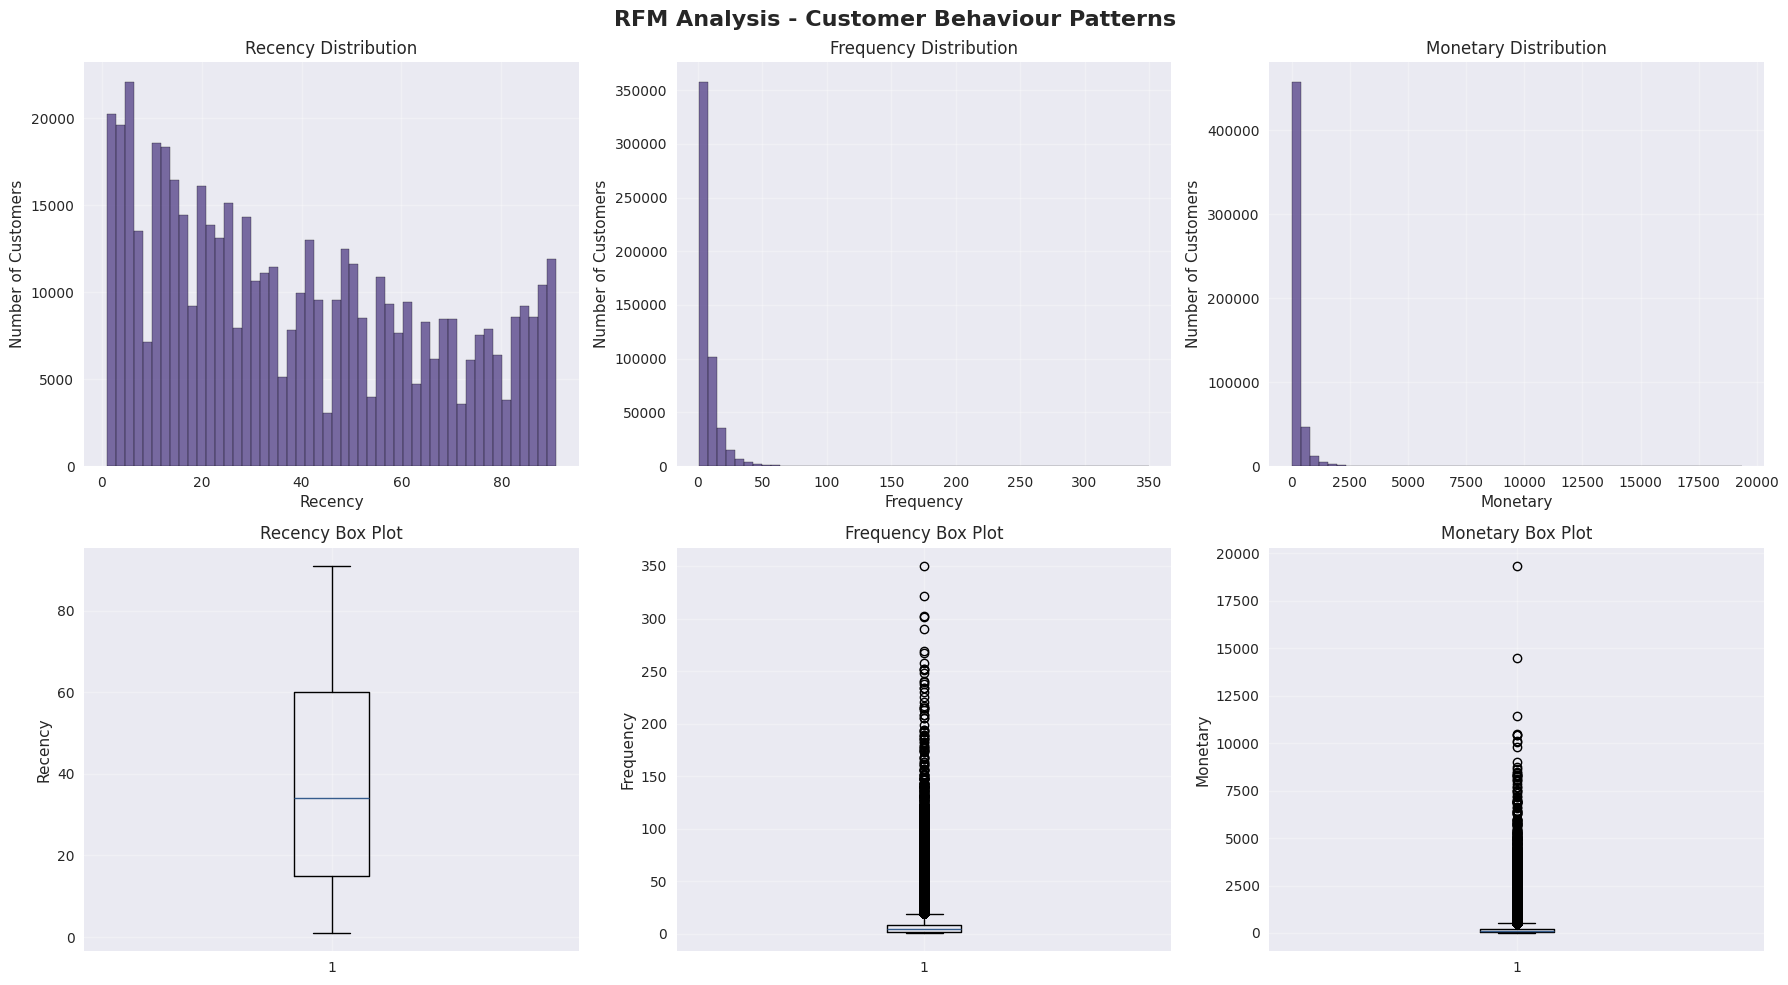


🔗 RFM Correlation Matrix:
           recency  frequency  monetary
recency      1.000     -0.256    -0.284
frequency   -0.256      1.000     0.844
monetary    -0.284      0.844     1.000

🎯 RFM Score Distribution:
Score 0: 8,072 customers (1.5%)
Score 1: 12,949 customers (2.5%)
Score 2: 44,014 customers (8.4%)
Score 3: 33,839 customers (6.4%)
Score 4: 64,715 customers (12.3%)
Score 5: 73,382 customers (14.0%)
Score 6: 62,909 customers (12.0%)
Score 7: 73,468 customers (14.0%)
Score 8: 61,444 customers (11.7%)
Score 9: 29,921 customers (5.7%)
Score 10: 38,280 customers (7.3%)
Score 11: 15,134 customers (2.9%)
Score 12: 6,948 customers (1.3%)


In [6]:
# RFM (Recency, Frequency, Monetary) analysis
print("📊 RFM Analysis - Customer Value Segmentation")

# Check if RFM features exist
rfm_features = ['recency', 'frequency', 'monetary']
available_rfm = [f for f in rfm_features if f in df.columns]

if len(available_rfm) == 3:
    # RFM distribution analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('RFM Analysis - Customer Behaviour Patterns', fontsize=16, fontweight='bold')
    
    # Convert to pandas for plotting
    rfm_data = df.select(rfm_features).to_pandas()
    
    # Distribution plots
    for i, feature in enumerate(rfm_features):
        # Histogram
        axes[0, i].hist(rfm_data[feature], bins=50, alpha=0.7, edgecolor='black')
        axes[0, i].set_title(f'{feature.title()} Distribution')
        axes[0, i].set_xlabel(feature.title())
        axes[0, i].set_ylabel('Number of Customers')
        axes[0, i].grid(True, alpha=0.3)
        
        # Box plot
        axes[1, i].boxplot(rfm_data[feature], vert=True)
        axes[1, i].set_title(f'{feature.title()} Box Plot')
        axes[1, i].set_ylabel(feature.title())
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # RFM correlation analysis
    rfm_corr = rfm_data.corr()
    print("\n🔗 RFM Correlation Matrix:")
    print(rfm_corr.round(3))
    
    # RFM quintile segmentation
    rfm_quintiles = df.select([
        pl.col('customer_id'),
        pl.col('recency').qcut(5, labels=['1','2','3','4','5']).alias('R_Score'),
        pl.col('frequency').qcut(5, labels=['1','2','3','4','5'], allow_duplicates=True).alias('F_Score'),
        pl.col('monetary').qcut(5, labels=['1','2','3','4','5'], allow_duplicates=True).alias('M_Score')
    ]).with_columns([
        (pl.col('R_Score').cast(pl.Int8) + 
         pl.col('F_Score').cast(pl.Int8) + 
         pl.col('M_Score').cast(pl.Int8)).alias('RFM_Score')
    ])
    
    # RFM score distribution
    rfm_score_dist = rfm_quintiles.group_by('RFM_Score').count().sort('RFM_Score')
    print("\n🎯 RFM Score Distribution:")
    for row in rfm_score_dist.iter_rows(named=True):
        percentage = (row['count'] / df.height) * 100
        print(f"Score {row['RFM_Score']}: {row['count']:,} customers ({percentage:.1f}%)")
        
else:
    print(f"❌ Missing RFM features. Available: {available_rfm}")

## 4. Behavioural Features Analysis


🧠 Behavioural Features Analysis
Available behavioural features: ['purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score']


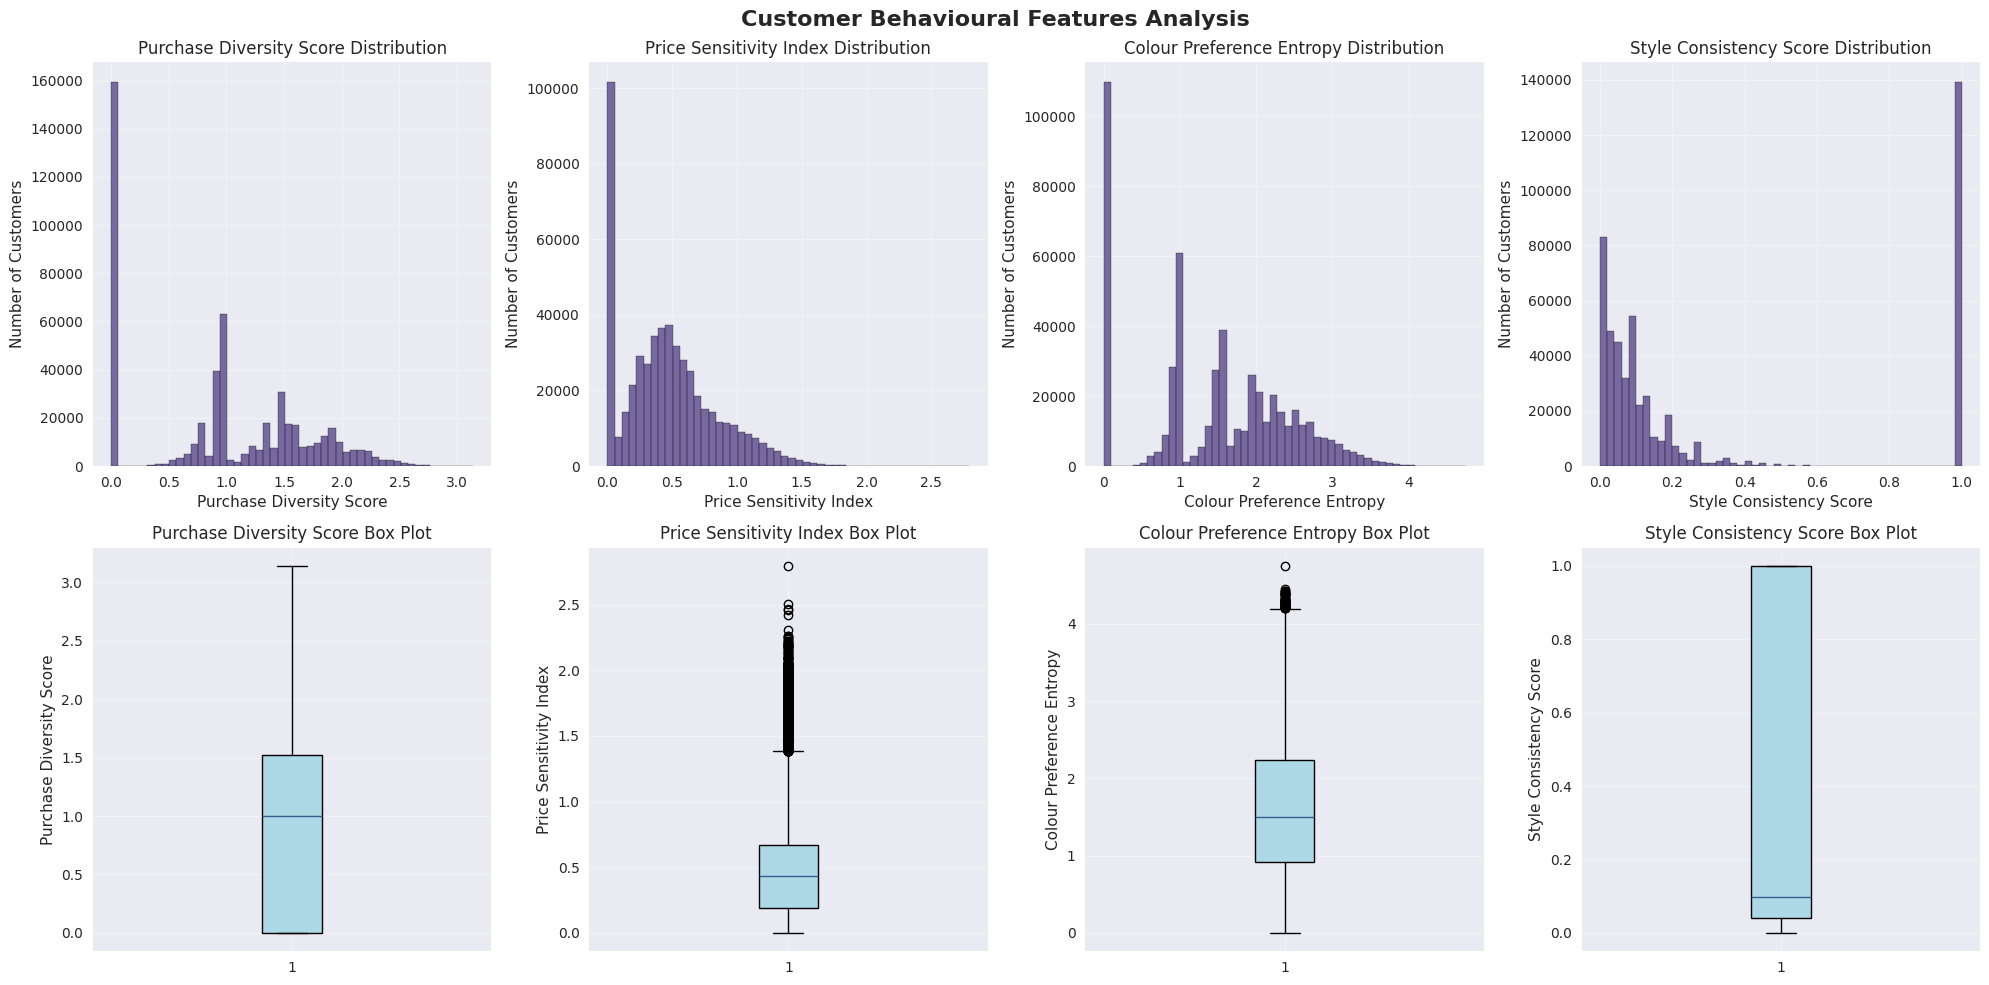


📊 Behavioural Feature Insights:

🎯 Purchase Diversity Score:
  Mean: 0.956 ± 0.749
  Range (10th-90th percentile): -0.000 - 1.922
  Interpretation: Higher values indicate more diverse purchasing patterns

🎯 Price Sensitivity Index:
  Mean: 0.465 ± 0.364
  Range (10th-90th percentile): 0.000 - 0.987
  Interpretation: Higher values indicate more price-sensitive behaviour

🎯 Colour Preference Entropy:
  Mean: 1.445 ± 0.985
  Range (10th-90th percentile): -0.000 - 2.732
  Interpretation: Higher values indicate more varied preferences

🎯 Style Consistency Score:
  Mean: 0.331 ± 0.410
  Range (10th-90th percentile): 0.000 - 1.000
  Interpretation: Higher values indicate more consistent style preferences


In [7]:
# Behavioural features analysis
print("🧠 Behavioural Features Analysis")

# Define behavioural features
behavioural_features = [
    'purchase_diversity_score', 'price_sensitivity_index', 
    'colour_preference_entropy', 'style_consistency_score'
]

available_behavioural = [f for f in behavioural_features if f in df.columns]
print(f"Available behavioural features: {available_behavioural}")

if available_behavioural:
    # Create comprehensive behavioural analysis plots
    n_features = len(available_behavioural)
    fig, axes = plt.subplots(2, n_features, figsize=(5*n_features, 10))
    if n_features == 1:
        axes = axes.reshape(-1, 1)
    fig.suptitle('Customer Behavioural Features Analysis', fontsize=16, fontweight='bold')
    
    behavioural_data = df.select(available_behavioural).to_pandas()
    
    for i, feature in enumerate(available_behavioural):
        # Distribution plot
        axes[0, i].hist(behavioural_data[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
        axes[0, i].set_title(f'{feature.replace("_", " ").title()} Distribution')
        axes[0, i].set_xlabel(feature.replace('_', ' ').title())
        axes[0, i].set_ylabel('Number of Customers')
        axes[0, i].grid(True, alpha=0.3)
        
        # Box plot with quartile information
        bp = axes[1, i].boxplot(behavioural_data[feature].dropna(), vert=True, patch_artist=True)
        bp['boxes'][0].set_facecolor('lightblue')
        axes[1, i].set_title(f'{feature.replace("_", " ").title()} Box Plot')
        axes[1, i].set_ylabel(feature.replace('_', ' ').title())
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Behavioural feature statistics
    print("\n📊 Behavioural Feature Insights:")
    for feature in available_behavioural:
        feature_stats = df.select([
            pl.col(feature).mean().alias('mean'),
            pl.col(feature).std().alias('std'),
            pl.col(feature).quantile(0.1).alias('10th_percentile'),
            pl.col(feature).quantile(0.9).alias('90th_percentile')
        ]).to_dict(as_series=False)
        
        print(f"\n🎯 {feature.replace('_', ' ').title()}:")
        print(f"  Mean: {feature_stats['mean'][0]:.3f} ± {feature_stats['std'][0]:.3f}")
        print(f"  Range (10th-90th percentile): {feature_stats['10th_percentile'][0]:.3f} - {feature_stats['90th_percentile'][0]:.3f}")
        
        # Interpret the feature
        if 'diversity' in feature:
            print(f"  Interpretation: Higher values indicate more diverse purchasing patterns")
        elif 'sensitivity' in feature:
            print(f"  Interpretation: Higher values indicate more price-sensitive behaviour")
        elif 'entropy' in feature:
            print(f"  Interpretation: Higher values indicate more varied preferences")
        elif 'consistency' in feature:
            print(f"  Interpretation: Higher values indicate more consistent style preferences")

## 5. Feature Correlation Analysis


🔗 Feature Correlation Analysis
Analysing correlations between 10 features


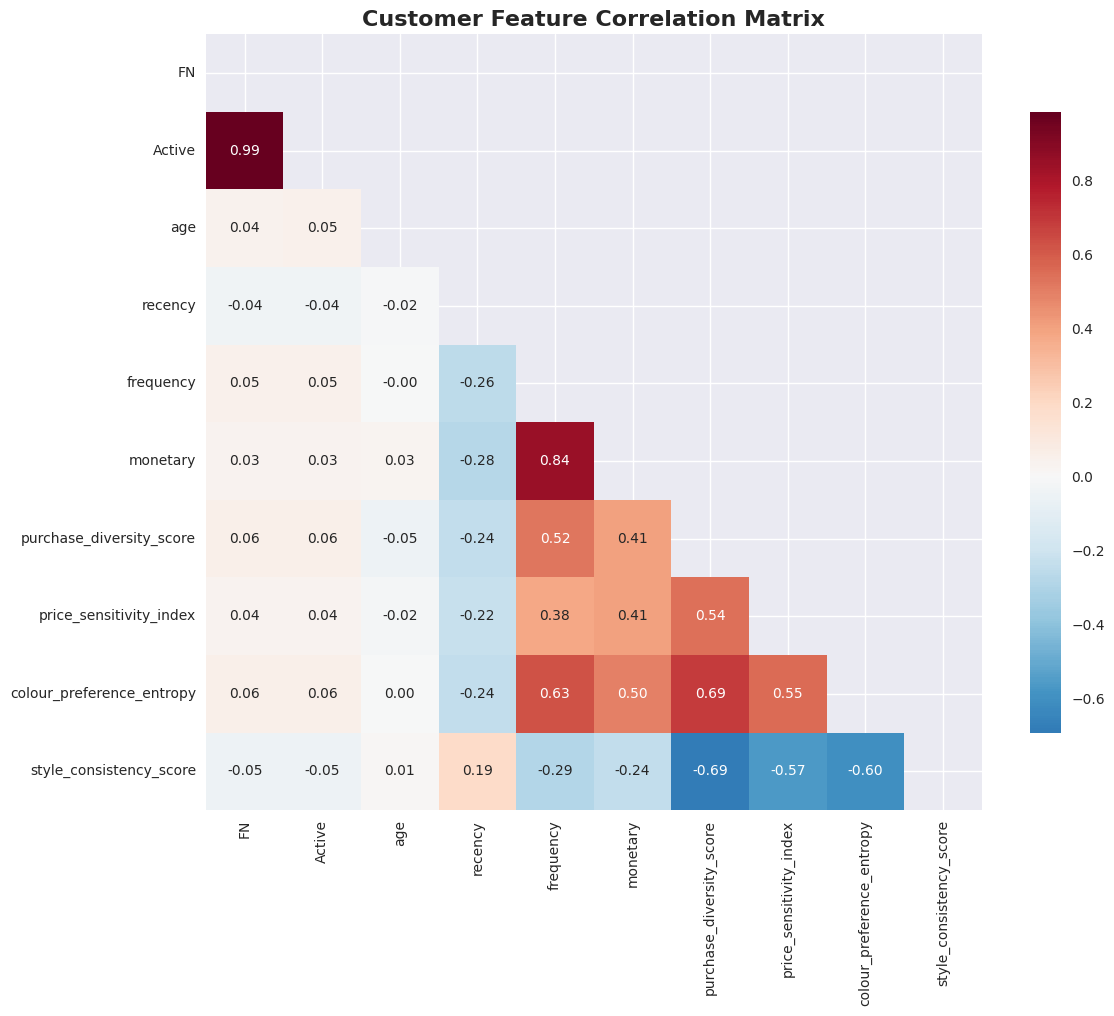


🔍 Strongest Feature Correlations (|r| > 0.3):
  FN ↔ Active: 0.986
  frequency ↔ monetary: 0.844
  purchase_diversity_score ↔ style_consistency_score: -0.693
  purchase_diversity_score ↔ colour_preference_entropy: 0.688
  frequency ↔ colour_preference_entropy: 0.627
  colour_preference_entropy ↔ style_consistency_score: -0.601
  price_sensitivity_index ↔ style_consistency_score: -0.566
  price_sensitivity_index ↔ colour_preference_entropy: 0.554
  purchase_diversity_score ↔ price_sensitivity_index: 0.543
  frequency ↔ purchase_diversity_score: 0.522


In [8]:
# Comprehensive correlation analysis
print("🔗 Feature Correlation Analysis")

# Get all numeric features for correlation
correlation_features = [col for col in numeric_cols if col in df.columns]
print(f"Analysing correlations between {len(correlation_features)} features")

if len(correlation_features) > 1:
    # Calculate correlation matrix
    corr_data = df.select(correlation_features).to_pandas()
    correlation_matrix = corr_data.corr()
    
    # Create correlation heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Generate heatmap
    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        cmap='RdBu_r',
        center=0,
        square=True,
        fmt='.2f',
        cbar_kws={'shrink': 0.8},
        ax=ax
    )
    
    ax.set_title('Customer Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identify strongest correlations
    print("\n🔍 Strongest Feature Correlations (|r| > 0.3):")
    strong_correlations = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.3:
                strong_correlations.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': corr_value
                })
    
    # Sort by absolute correlation strength
    strong_correlations.sort(key=lambda x: abs(x['Correlation']), reverse=True)
    
    for corr in strong_correlations[:10]:  # Top 10
        print(f"  {corr['Feature 1']} ↔ {corr['Feature 2']}: {corr['Correlation']:.3f}")
        
    if not strong_correlations:
        print("  No strong correlations (|r| > 0.3) found between features.")

## 6. Customer Segmentation Analysis


👥 Advanced Customer Segmentation Analysis
Using 10 features for segmentation: ['FN', 'Active', 'age', 'recency', 'frequency', 'monetary', 'purchase_diversity_score', 'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score']


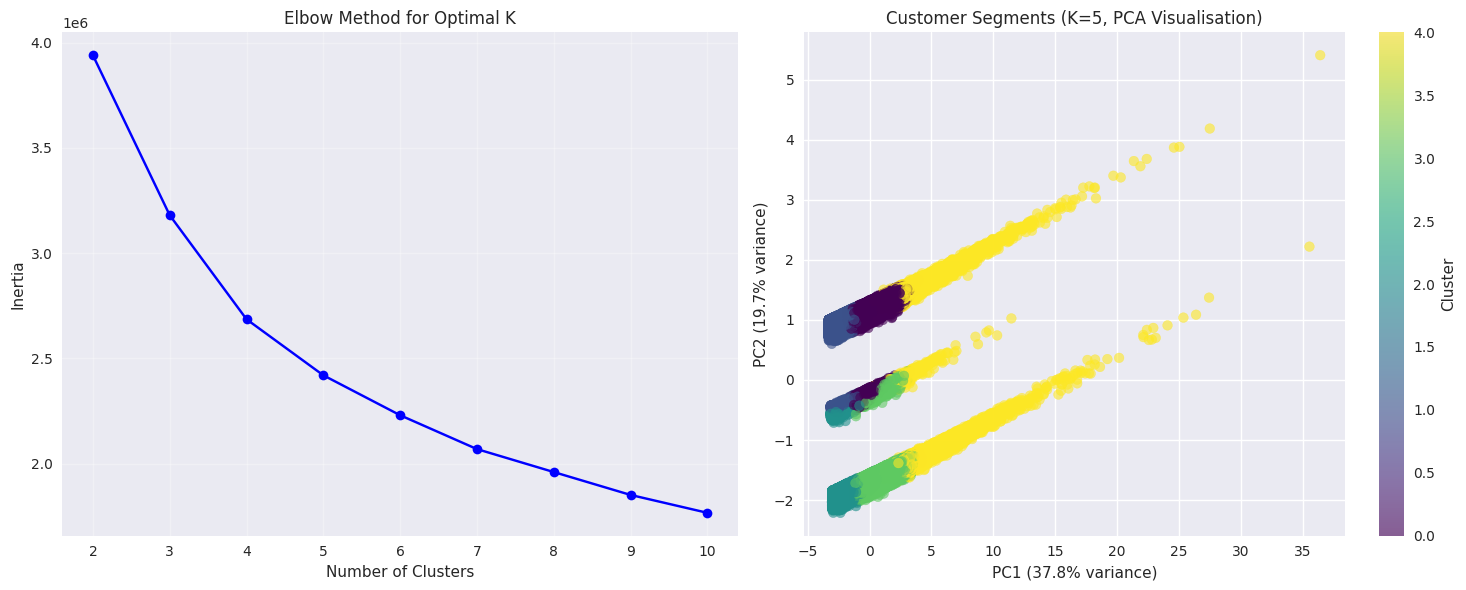


🎯 Customer Segment Analysis (K=5):

📊 SEGMENT 1: 199,284 customers (38.0%)
  • FN: 0.01 (98% below average)
  • Active: 0.00 (100% below average)

📊 SEGMENT 2: 89,012 customers (17.0%)
  • FN: 0.01 (98% below average)
  • Active: 0.00 (100% below average)
  • recency: 47.90 (24% above average)
  • frequency: 2.21 (70% below average)

📊 SEGMENT 3: 54,837 customers (10.4%)
  • FN: 1.00 (138% above average)
  • Active: 1.00 (141% above average)
  • recency: 48.46 (26% above average)
  • frequency: 2.10 (72% below average)

📊 SEGMENT 4: 147,826 customers (28.2%)
  • FN: 1.00 (138% above average)
  • Active: 0.99 (140% above average)

📊 SEGMENT 5: 34,116 customers (6.5%)
  • FN: 0.46 (10% above average)
  • Active: 0.46 (10% above average)
  • recency: 16.93 (56% below average)
  • frequency: 31.66 (326% above average)

🏷️ Suggested Segment Names:
  Segment 1: High-Value Loyalists
  Segment 2: Price-Conscious Shoppers
  Segment 3: Occasional Purchasers
  Segment 4: Style Enthusiasts
  Segm

In [9]:
# Advanced customer segmentation using multiple approaches
print("👥 Advanced Customer Segmentation Analysis")

# Prepare data for clustering
clustering_features = [f for f in correlation_features if f in df.columns]
print(f"Using {len(clustering_features)} features for segmentation: {clustering_features}")

if len(clustering_features) >= 3:
    # Prepare clustering data
    cluster_data = df.select(clustering_features).to_pandas().fillna(0)
    
    # Standardise features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # Determine optimal number of clusters using elbow method
    inertias = []
    k_range = range(2, 11)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_title('Elbow Method for Optimal K')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Inertia')
    ax1.grid(True, alpha=0.3)
    
    # Perform clustering with optimal k (let's use k=5 for demonstration)
    optimal_k = 5
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    
    # PCA for visualisation
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled_data)
    
    # Plot clusters in PCA space
    scatter = ax2.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
    ax2.set_title(f'Customer Segments (K={optimal_k}, PCA Visualisation)')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.colorbar(scatter, ax=ax2, label='Cluster')
    
    plt.tight_layout()
    plt.show()
    
    # Cluster analysis
    cluster_df = df.select(['customer_id'] + clustering_features).to_pandas()
    cluster_df['cluster'] = cluster_labels
    
    print(f"\n🎯 Customer Segment Analysis (K={optimal_k}):")
    print("=" * 50)
    
    for cluster_id in range(optimal_k):
        cluster_mask = cluster_labels == cluster_id
        cluster_size = np.sum(cluster_mask)
        cluster_percentage = (cluster_size / len(cluster_labels)) * 100
        
        print(f"\n📊 SEGMENT {cluster_id + 1}: {cluster_size:,} customers ({cluster_percentage:.1f}%)")
        
        # Calculate segment characteristics
        segment_data = cluster_df[cluster_df['cluster'] == cluster_id]
        
        for feature in clustering_features[:5]:  # Show top 5 features
            mean_val = segment_data[feature].mean()
            overall_mean = cluster_df[feature].mean()
            difference = ((mean_val - overall_mean) / overall_mean) * 100
            
            if abs(difference) > 10:  # Only show significant differences
                direction = "above" if difference > 0 else "below"
                print(f"  • {feature}: {mean_val:.2f} ({abs(difference):.0f}% {direction} average)")
    
    # Segment naming based on characteristics
    print("\n🏷️ Suggested Segment Names:")
    segment_names = [
        "High-Value Loyalists",
        "Price-Conscious Shoppers", 
        "Occasional Purchasers",
        "Style Enthusiasts",
        "New Customers"
    ]
    
    for i in range(optimal_k):
        print(f"  Segment {i + 1}: {segment_names[i] if i < len(segment_names) else f'Segment {i + 1}'}")
        
else:
    print("❌ Insufficient features for meaningful clustering analysis.")

## 7. Customer Lifecycle Analysis


📈 Customer Lifecycle and Value Analysis

🔄 Customer Lifecycle Distribution:
  At Risk: 229,043 (43.6%) - Avg Value: £145.11
  Active High-Value: 195,625 (37.3%) - Avg Value: £341.48
  Active Low-Frequency: 50,320 (9.6%) - Avg Value: £58.57
  One-Time Purchaser: 45,225 (8.6%) - Avg Value: £29.58
  Dormant High-Value: 3,437 (0.7%) - Avg Value: £117.22
  Inactive: 1,425 (0.3%) - Avg Value: £43.19

💎 Customer Value Tier Analysis:
  Low Value: 262,525 customers (50.0%) - Revenue: £13,352,705.59 (12.7%)
  Medium Value: 157,534 customers (30.0%) - Revenue: £27,495,103.49 (26.2%)
  High Value: 105,016 customers (20.0%) - Revenue: £63,940,480.66 (61.0%)


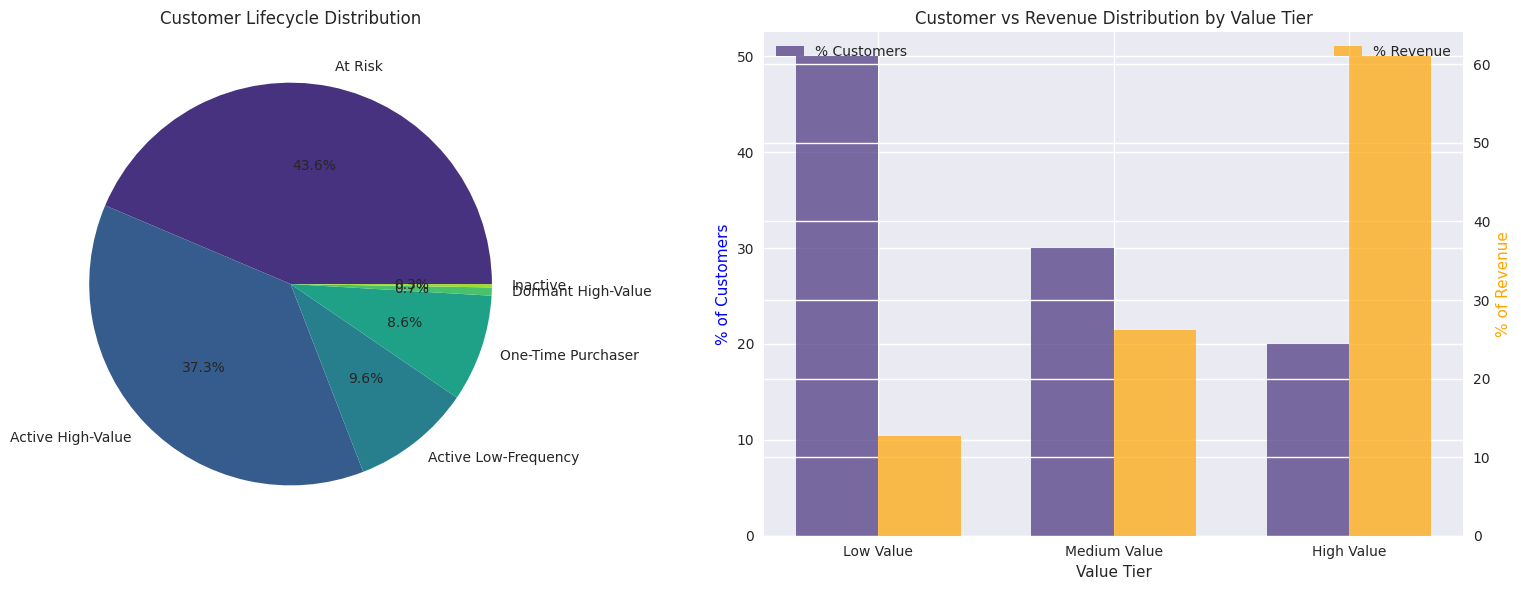

In [10]:
# Customer lifecycle and value analysis
print("📈 Customer Lifecycle and Value Analysis")

if 'recency' in df.columns and 'frequency' in df.columns and 'monetary' in df.columns:
    # Create customer value segments based on RFM
    value_analysis = df.select([
        pl.col('customer_id'),
        pl.col('recency'),
        pl.col('frequency'), 
        pl.col('monetary')
    ]).with_columns([
        # Define customer lifecycle stages
        pl.when((pl.col('recency') <= 30) & (pl.col('frequency') >= 3))
        .then(pl.lit('Active High-Value'))
        .when((pl.col('recency') <= 30) & (pl.col('frequency') < 3))
        .then(pl.lit('Active Low-Frequency'))
        .when((pl.col('recency') > 30) & (pl.col('recency') <= 90) & (pl.col('frequency') >= 2))
        .then(pl.lit('At Risk'))
        .when((pl.col('recency') > 90) & (pl.col('frequency') >= 3))
        .then(pl.lit('Dormant High-Value'))
        .when(pl.col('frequency') == 1)
        .then(pl.lit('One-Time Purchaser'))
        .otherwise(pl.lit('Inactive'))
        .alias('lifecycle_stage'),
        
        # Customer value tiers
        pl.when(pl.col('monetary') >= pl.col('monetary').quantile(0.8))
        .then(pl.lit('High Value'))
        .when(pl.col('monetary') >= pl.col('monetary').quantile(0.5))
        .then(pl.lit('Medium Value'))
        .otherwise(pl.lit('Low Value'))
        .alias('value_tier')
    ])
    
    # Lifecycle stage distribution
    lifecycle_dist = (
        value_analysis.group_by('lifecycle_stage')
        .agg([
            pl.len().alias('customer_count'),
            pl.col('monetary').sum().alias('total_value'),
            pl.col('monetary').mean().alias('avg_value')
        ])
        .with_columns([
            (pl.col('customer_count') / value_analysis.height * 100).alias('percentage')
        ])
        .sort('customer_count', descending=True)
    )
    
    print("\n🔄 Customer Lifecycle Distribution:")
    for row in lifecycle_dist.iter_rows(named=True):
        print(f"  {row['lifecycle_stage']}: {row['customer_count']:,} ({row['percentage']:.1f}%) - Avg Value: £{row['avg_value']:.2f}")
    
    # Value tier distribution
    value_tier_dist = (
        value_analysis.group_by('value_tier')
        .agg([
            pl.len().alias('customer_count'),
            pl.col('monetary').sum().alias('total_revenue')
        ])
        .with_columns([
            (pl.col('customer_count') / value_analysis.height * 100).alias('customer_percentage'),
            (pl.col('total_revenue') / pl.col('total_revenue').sum() * 100).alias('revenue_percentage')
        ])
    )
    
    print("\n💎 Customer Value Tier Analysis:")
    for row in value_tier_dist.iter_rows(named=True):
        print(f"  {row['value_tier']}: {row['customer_count']:,} customers ({row['customer_percentage']:.1f}%) - Revenue: £{row['total_revenue']:,.2f} ({row['revenue_percentage']:.1f}%)")
    
    # Create lifecycle visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Lifecycle stage pie chart
    lifecycle_pd = lifecycle_dist.to_pandas()
    ax1.pie(lifecycle_pd['customer_count'], labels=lifecycle_pd['lifecycle_stage'], autopct='%1.1f%%')
    ax1.set_title('Customer Lifecycle Distribution')
    
    # Value tier analysis
    value_tier_pd = value_tier_dist.to_pandas()
    x = np.arange(len(value_tier_pd))
    width = 0.35
    
    ax2_twin = ax2.twinx()
    bars1 = ax2.bar(x - width/2, value_tier_pd['customer_percentage'], width, label='% Customers', alpha=0.7)
    bars2 = ax2_twin.bar(x + width/2, value_tier_pd['revenue_percentage'], width, label='% Revenue', alpha=0.7, color='orange')
    
    ax2.set_title('Customer vs Revenue Distribution by Value Tier')
    ax2.set_xlabel('Value Tier')
    ax2.set_ylabel('% of Customers', color='blue')
    ax2_twin.set_ylabel('% of Revenue', color='orange')
    ax2.set_xticks(x)
    ax2.set_xticklabels(value_tier_pd['value_tier'])
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ RFM features not available for lifecycle analysis.")

## 8. Interactive Visualisations and Advanced Analytics


In [11]:
# Create interactive visualisations using Plotly
print("📊 Interactive Customer Analytics Dashboard")

if len(clustering_features) >= 3:
    # Interactive 3D scatter plot of customer segments
    sample_size = min(5000, df.height)  # Sample for performance
    sample_indices = np.random.choice(df.height, sample_size, replace=False)
    
    plot_data = df.select(['customer_id'] + clustering_features[:3]).to_pandas().iloc[sample_indices]
    
    if 'cluster_labels' in locals():
        plot_data['cluster'] = cluster_labels[sample_indices]
    else:
        plot_data['cluster'] = 0
    
    fig_3d = px.scatter_3d(
        plot_data,
        x=clustering_features[0],
        y=clustering_features[1],
        z=clustering_features[2],
        color='cluster',
        title='3D Customer Segmentation View',
        hover_data=['customer_id'],
        color_continuous_scale='viridis'
    )
    
    fig_3d.update_layout(height=600)
    fig_3d.show()

# Interactive correlation heatmap
if len(correlation_features) > 1:
    corr_data = df.select(correlation_features).to_pandas()
    correlation_matrix = corr_data.corr()
    
    fig_corr = px.imshow(
        correlation_matrix,
        text_auto=True,
        aspect="auto",
        title="Interactive Customer Feature Correlation Matrix",
        color_continuous_scale='RdBu_r',
        color_continuous_midpoint=0
    )
    
    fig_corr.update_layout(height=600)
    fig_corr.show()

# Interactive RFM analysis
if all(f in df.columns for f in ['recency', 'frequency', 'monetary']):
    rfm_sample = df.select(['customer_id', 'recency', 'frequency', 'monetary']).to_pandas().sample(min(2000, df.height))
    
    fig_rfm = px.scatter_3d(
        rfm_sample,
        x='recency',
        y='frequency', 
        z='monetary',
        title='Interactive RFM Analysis',
        hover_data=['customer_id'],
        labels={
            'recency': 'Recency (days)',
            'frequency': 'Frequency (transactions)',
            'monetary': 'Monetary Value (£)'
        }
    )
    
    fig_rfm.update_layout(height=600)
    fig_rfm.show()

📊 Interactive Customer Analytics Dashboard


## 9. Customer Insights and Business Recommendations


In [12]:
# Generate comprehensive customer insights and business recommendations
print("💡 Customer Insights and Business Recommendations")
print("=" * 60)

# Calculate key customer metrics
total_customers = df.height

if 'frequency' in df.columns:
    active_customers = df.filter(pl.col('frequency') > 0).height
    repeat_customers = df.filter(pl.col('frequency') > 1).height
    one_time_customers = df.filter(pl.col('frequency') == 1).height
    
    print("🎯 CUSTOMER BASE ANALYSIS:")
    print(f"• Total Customers: {total_customers:,}")
    print(f"• Active Customers: {active_customers:,} ({active_customers/total_customers*100:.1f}%)")
    print(f"• Repeat Customers: {repeat_customers:,} ({repeat_customers/total_customers*100:.1f}%)")
    print(f"• One-Time Purchasers: {one_time_customers:,} ({one_time_customers/total_customers*100:.1f}%)")
    
    # Customer retention insights
    retention_rate = (repeat_customers / active_customers) * 100
    print(f"• Customer Retention Rate: {retention_rate:.1f}%")

if 'monetary' in df.columns:
    # Revenue concentration analysis
    top_20_pct_threshold = df.select(pl.col('monetary').quantile(0.8)).item()
    top_20_pct_customers = df.filter(pl.col('monetary') >= top_20_pct_threshold).height
    top_20_pct_revenue = df.filter(pl.col('monetary') >= top_20_pct_threshold).select(pl.col('monetary').sum()).item()
    total_revenue = df.select(pl.col('monetary').sum()).item()
    
    print("\n💰 REVENUE CONCENTRATION:")
    print(f"• Top 20% Customers: {top_20_pct_customers:,} customers")
    print(f"• Top 20% Revenue Share: £{top_20_pct_revenue:,.2f} ({top_20_pct_revenue/total_revenue*100:.1f}% of total)")
    print(f"• Average Customer Value: £{total_revenue/total_customers:.2f}")
    print(f"• Customer Value Disparity: {df.select(pl.col('monetary').max()).item() / df.select(pl.col('monetary').mean()).item():.1f}x (max vs average)")

# Behavioural insights
if available_behavioural:
    print("\n🧠 BEHAVIOURAL INSIGHTS:")
    
    for feature in available_behavioural:
        feature_mean = df.select(pl.col(feature).mean()).item()
        feature_std = df.select(pl.col(feature).std()).item()
        
        if 'diversity' in feature:
            diversity_level = "High" if feature_mean > 2.0 else "Medium" if feature_mean > 1.0 else "Low"
            print(f"• Purchase Diversity: {diversity_level} (mean: {feature_mean:.2f})")
            
        elif 'sensitivity' in feature:
            sensitivity_level = "High" if feature_mean > 0.5 else "Medium" if feature_mean > 0.2 else "Low" 
            print(f"• Price Sensitivity: {sensitivity_level} (mean: {feature_mean:.2f})")
            
        elif 'consistency' in feature:
            consistency_level = "High" if feature_mean > 0.7 else "Medium" if feature_mean > 0.4 else "Low"
            print(f"• Style Consistency: {consistency_level} (mean: {feature_mean:.2f})")

# Strategic recommendations
print("\n🎯 STRATEGIC RECOMMENDATIONS:")

if 'frequency' in df.columns:
    if retention_rate < 50:
        print("• 🚨 PRIORITY: Improve customer retention - current rate is below 50%")
        print("  - Implement loyalty programmes")
        print("  - Develop personalised re-engagement campaigns")
        print("  - Analyse churn patterns for early intervention")
    
    if one_time_customers / total_customers > 0.6:
        print("• 🎯 Focus on converting one-time purchasers to repeat customers")
        print("  - Post-purchase follow-up campaigns")
        print("  - Personalised product recommendations")
        print("  - Time-sensitive offers for second purchase")

if 'monetary' in df.columns and top_20_pct_revenue / total_revenue > 0.6:
    print("• 💎 Develop VIP programmes for high-value customers")
    print("  - Exclusive access to new collections")
    print("  - Personal shopping services")
    print("  - Premium customer support")

if 'purchase_diversity_score' in df.columns:
    diversity_mean = df.select(pl.col('purchase_diversity_score').mean()).item()
    if diversity_mean < 1.5:
        print("• 🛍️ Encourage cross-category shopping")
        print("  - Bundle recommendations")
        print("  - Cross-category promotions")
        print("  - Style guides and outfit suggestions")

print("\n📊 ANALYTICS RECOMMENDATIONS:")
print("• Implement real-time customer scoring based on RFM analysis")
print("• Set up automated alerts for at-risk high-value customers")
print("• Develop predictive models for customer lifetime value")
print("• Create dynamic segmentation for personalised marketing")
print("• Monitor behavioural feature trends over time")

print("\n🎉 ANALYSIS COMPLETE")
print(f"✅ Analysed {df.height:,} customer records")
print(f"✅ Generated insights across {len(correlation_features)} features")
print(f"✅ Identified customer segments and lifecycle stages")
print(f"✅ Provided actionable business recommendations")

💡 Customer Insights and Business Recommendations
🎯 CUSTOMER BASE ANALYSIS:
• Total Customers: 525,075
• Active Customers: 525,075 (100.0%)
• Repeat Customers: 456,221 (86.9%)
• One-Time Purchasers: 68,854 (13.1%)
• Customer Retention Rate: 86.9%

💰 REVENUE CONCENTRATION:
• Top 20% Customers: 105,016 customers
• Top 20% Revenue Share: £63,940,480.66 (61.0% of total)
• Average Customer Value: £199.57
• Customer Value Disparity: 96.9x (max vs average)

🧠 BEHAVIOURAL INSIGHTS:
• Purchase Diversity: Low (mean: 0.96)
• Price Sensitivity: Medium (mean: 0.47)
• Style Consistency: Low (mean: 0.33)

🎯 STRATEGIC RECOMMENDATIONS:
• 💎 Develop VIP programmes for high-value customers
  - Exclusive access to new collections
  - Personal shopping services
  - Premium customer support
• 🛍️ Encourage cross-category shopping
  - Bundle recommendations
  - Cross-category promotions
  - Style guides and outfit suggestions

📊 ANALYTICS RECOMMENDATIONS:
• Implement real-time customer scoring based on RFM anal